# pix2pix

Adapted from https://github.com/eriklindernoren/PyTorch-GAN/tree/master/implementations/pix2pix

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Change local path to files and test that it works (change local_path and path in sys.path.append)

#Path to Pix2Pix directory
local_path = '/content/drive/MyDrive/Pix2Pix/'
!ls '{local_path}'

#Path to libraries directory
sys.path.append('/content/drive/MyDrive/Pix2Pix/libraries')

conda_environment.yml			images	    original_sources
demucs_test_separated_flat		libraries   README.md
files					LICENSE.md  results.pkl
generative_audio_inpainting_report.pdf	notebooks   saves


In [ ]:
import os
import numpy as np
import math
import itertools
import time
import datetime
import sys
import pickle
from multiprocessing import Pool
import resource
from tqdm import tqdm



import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


#from models.pix2pix import *
from models.MelGAN import *
from models.unet import *
from mlp import audio
from mlp import normalization
from mlp import utils as mlp
#from mlp.MelDataset import MusicDataset
from mlp.WaveDataset import MusicDataset

%load_ext autoreload

In [ ]:
%matplotlib inline
%autoreload

In [ ]:
epoch = 0 # epoch to start training from
n_epochs = 1000 # number of epochs of training
dataset_name = 'MUSDB-18' # name of the dataset
batch_size = 4 # size of the batches
lr = 0.0001 # adam: learning rate
b1 = 0.5 # adam: decay of first order momentum of gradient
b2 = 0.9 # adam: decay of first order momentum of gradient
decay_epoch = 100 # epoch from which to start lr decay
n_cpu = 4 # number of cpu threads to use during batch generation
img_height = 128 # size of image height
img_width = 128 # size of image width
channels = 1 # number of image channels
sample_interval = 100 # interval between sampling of images from generators
checkpoint_interval = 100 # interval between model checkpoints
n_layers_D = 4
num_D = 4

In [ ]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, resource.getrlimit(resource.RLIMIT_NOFILE)[1]))

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.MSELoss()

# Loss weight of L1 pixel-wise loss between translated image and real image
l = 1

# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height//2**4, img_width//2**4)

In [ ]:
class UNet(nn.Module):
    def __init__(self, leaky_relu=False, dropout=0.0):
        super(UNet, self).__init__()
        self.inc = inconv(1, 64, leaky_relu=leaky_relu)
        self.down1 = down(64, 128, leaky_relu=leaky_relu)
        self.down2 = down(128, 256, leaky_relu=leaky_relu)
        self.down3 = down(256, 512, leaky_relu=leaky_relu)
        # self.down4 = down(512, 1024, leaky_relu=leaky_relu, dropout=dropout)
        # self.down5 = down(1024, 1024, leaky_relu=leaky_relu, dropout=dropout)
        self.down4 = down(512, 1024, leaky_relu=leaky_relu)
        #self.down5 = down(1024, 2048, leaky_relu=leaky_relu, dropout=dropout)
        #self.down6 = down(2048, 2048, leaky_relu=leaky_relu, dropout=dropout)
        self.down5 = down(1024, 2048, leaky_relu=leaky_relu)
        self.down6 = down(2048, 4096, leaky_relu=leaky_relu, dropout=dropout)
        self.down7 = down(4096, 4096, leaky_relu=leaky_relu, dropout=dropout)
        self.up01 = up(8192,2048, bilinear=True, leaky_relu=leaky_relu, dropout=dropout)
        self.up02 = up(4096,1024, bilinear=True, leaky_relu=leaky_relu, dropout=dropout)
        self.up0 = up(2048,512, bilinear=True, leaky_relu=leaky_relu)
        #self.up01 = up(4096,1024, bilinear=True, leaky_relu=leaky_relu, dropout=dropout)
        #self.up0 = up(2048,512, bilinear=True, leaky_relu=leaky_relu, dropout=dropout)
        self.up1 = up(1024, 256, bilinear=True, leaky_relu=leaky_relu)
        # self.up0 = up(2048,512, bilinear=True, leaky_relu=leaky_relu, dropout=dropout)
        # self.up1 = up(1024, 256, bilinear=True, leaky_relu=leaky_relu, dropout=dropout)
        self.up2 = up(512, 128, bilinear=True, leaky_relu=leaky_relu)
        self.up3 = up(256, 64, bilinear=True, leaky_relu=leaky_relu)
        self.up4 = up(128, 64, bilinear=True, leaky_relu=leaky_relu)
        self.outc = outconv(64, 1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x7 = self.down6(x6)
        x8 = self.down7(x7)
        x = self.up01(x8, x7)
        x = self.up02(x, x6)
        x = self.up0(x, x5)
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [ ]:
'''
#pretrained_generator = UNet(leaky_relu=False, dropout=0.0).to(device)
generator = UNet(leaky_relu=True, dropout=0.2).to(device)
discriminator = Discriminator2(in_channels=channels).to(device)

if cuda:
    generator = generator.cuda()
    #pretrained_generator = pretrained_generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

#if cuda:
    #pretrained_generator.load_state_dict(torch.load(local_path+ '/files/32_64_model_final.pt'))
#else:
   # pretrained_generator.load_state_dict(torch.load(local_path+'/files/32_64_model_final.pt', map_location='cpu'))
    
if epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load('generator_%d.pth' % (epoch)))
    discriminator.load_state_dict(torch.load('discriminator_%d.pth' % (epoch)))
#else:
    # Initialize weights
    #generator.apply(weights_init_normal)
    #if cuda:
        #generator.load_state_dict(torch.load(local_path+ 'files/32_64_model_final.pt'))
    #else:
        #generator.load_state_dict(torch.load(local_path+ 'files/32_64_model_final.pt', map_location='cpu'))
    #discriminator.apply(weights_init_normal)

# Optimizers

#optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
#optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr,betas=(b1,b2))
'''

n_mel_channels = 80
ngf = 32
n_residual_layers = 3

num_D = 3
ndf = 16
n_layers_D = 4
downsamp_factor = 4
lambda_feat = 10
save_interval = 20
log_interval = 100

netG = GeneratorMel(n_mel_channels, ngf, n_residual_layers).cuda()
netD = DiscriminatorMel(
        num_D, ndf, n_layers_D, downsamp_factor
    ).cuda()
fft = Audio2Mel(n_mel_channels=n_mel_channels).cuda()

optG = torch.optim.Adam(netG.parameters(), lr=1e-4, betas=(0.5, 0.9))
optD = torch.optim.Adam(netD.parameters(), lr=1e-4, betas=(0.5, 0.9))


In [ ]:
dirty_path ='/content/drive/MyDrive/Pix2Pix/demucs_test_separated_flat'
clean_path ='/content/drive/MyDrive/Pix2Pix/original_sources'

train_dirty = []
train_clean = []
val_dirty = []
val_clean = []

for s in os.listdir(dirty_path):
  if np.random.rand() < .8:
    train_dirty.append(dirty_path + '/' + s)
    train_clean.append(clean_path +'/' + s)
  else:
    val_dirty.append(dirty_path +'/' + s)
    val_clean.append(clean_path + '/' + s)

In [ ]:
fs = 48000
bs = batch_size
stroke_width = 32
patch_width = img_width
patch_height = img_height
nperseg = 256

#train_files = pickle.load(open(local_path+ "/files/train.pk", "rb"))[:1]
#val_files = pickle.load(open(local_path+ "/files/valid.pk", "rb"))[:1]



ds_valid = MusicDataset(val_clean,val_dirty,44100,44100)
ds_train = MusicDataset(train_clean,train_dirty,44100,44100)


valid_loader = DataLoader(ds_valid, batch_size=bs, num_workers=2, shuffle=False)
train_loader = DataLoader(ds_train, batch_size=bs, num_workers=2, shuffle=True)



#with Pool(8) as p:
#    train_dss = []
#    
#    for i in range(1):
#        train_dss.append(WAVAudioDS(train_files[i*4000:(i+1)*4000], mk_source=lambda x: x * purge_mask, 
#                                    preprocess=preprocess, patch_width=patch_width, proc_pool=p, 
#                                    nperseg=256, random_patches=True))

#    ds_train = MultiSet(train_dss)
#    ds_test = WAVAudioDS(val_files, mk_source=lambda x: x * purge_mask, preprocess=preprocess, 
#                          patch_width=patch_width, proc_pool=p, nperseg=256, random_patches=False)

#val_dataloader = DataLoader(ds_train, batch_size=bs, num_workers=8, shuffle=True)
#dataloader = DataLoader(ds_test, batch_size=bs, num_workers=8, shuffle=False)

Dataset Validation Successful
Dataset Validation Successful


In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def sample_images(epoch, batches_done):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(val_dataloader))
    real_A = Variable(imgs[0].type(Tensor))
    real_B = Variable(imgs[1].type(Tensor))
    

    real_A = real_A.unsqueeze(1)
    real_B = real_B.unsqueeze(1)

    recon_B = generator(real_A.to(device)).detach()
    recon_B = real_A + stroke_mask_not.float()*recon_B
    recon_B_old = pretrained_generator(real_A.to(device)).detach()
    recon_B_old = real_A + stroke_mask_not.float()*recon_B_old
    
    img_sample = torch.cat((real_A.detach(), recon_B.detach(), recon_B_old.detach(), real_B.detach()), -2)
    torch.save(img_sample, '%s_%s.pt' % (epoch, batches_done))

# Training

In [ ]:
netG.load_state_dict(torch.load(local_path +'saves/' +  str(200) + "netG.pt"))

<All keys matched successfully>

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
costs = []
start = time.time()

#prev_time = time.time()
results = []
#real_A = torch.from_numpy(ds_train[0][0]).unsqueeze(0).unsqueeze(1).to(device)
#real_B = torch.from_numpy(ds_train[0][1]).unsqueeze(0).unsqueeze(1).to(device)

dis_train = 0
steps = 0
for epoch in range(200, n_epochs):
    if epoch % 100 == 0:
      torch.save(netG.state_dict(), local_path +'saves/' +  str(epoch) + "netG.pt")
    for iterno, x_t in enumerate(train_loader):
          x_t_0 = x_t[0].unsqueeze(1).float().cuda()
          x_t_1 = x_t[1].unsqueeze(1).float().cuda()
          s_t = fft(x_t_0).detach()
          x_pred_t = netG(s_t.cuda())
          with torch.no_grad():
              s_pred_t = fft(x_pred_t.detach())
              s_error = F.l1_loss(s_t, s_pred_t).item()

            #######################
            # Train Discriminator #
            #######################


          
          x_t_1 = x_t_1[:,:,:44032]
          D_fake_det = netD(x_pred_t.cuda().detach())
          D_real = netD(x_t_1.cuda())

          loss_D = 0
          for scale in D_fake_det:
              loss_D += F.relu(1 + scale[-1]).mean()

          for scale in D_real:
              loss_D += F.relu(1 - scale[-1]).mean()

          netD.zero_grad()
          loss_D.backward()
          optD.step()

            ###################
            # Train Generator #
            ###################
          D_fake = netD(x_pred_t.cuda())

          loss_G = 0
          for scale in D_fake:
              loss_G += -scale[-1].mean()

          loss_feat = 0
          feat_weights = 4.0 / (n_layers_D + 1)
          D_weights = 1.0 / num_D
          wt = D_weights * feat_weights
          for i in range(num_D):
              for j in range(len(D_fake[i]) - 1):
                  loss_feat += wt * F.l1_loss(D_fake[i][j], D_real[i][j].detach())

          netG.zero_grad()
          (loss_G + lambda_feat * loss_feat).backward()
          optG.step()

            ######################
            # Update tensorboard #
            ######################
          costs.append([loss_D.item(), loss_G.item(), loss_feat.item(), s_error])

          writer.add_scalar("loss/discriminator", costs[-1][0], steps)
          writer.add_scalar("loss/generator", costs[-1][1], steps)
          writer.add_scalar("loss/feature_matching", costs[-1][2], steps)
          writer.add_scalar("loss/mel_reconstruction", costs[-1][3], steps)
          steps += 1
          '''
          if steps % save_interval == 0:
              st = time.time()
              with torch.no_grad():
                  for i, (voc, _) in enumerate(zip(test_voc, test_audio)):
                      pred_audio = netG(voc)
                      pred_audio = pred_audio.squeeze().cpu()
                      save_sample(root / ("generated_%d.wav" % i), 44100, pred_audio)
                      writer.add_audio(
                          "generated/sample_%d.wav" % i,
                          pred_audio,
                          epoch,
                          sample_rate=44100,
                        )

              torch.save(netG.state_dict(), root / "netG.pt")
              torch.save(optG.state_dict(), root / "optG.pt")

              torch.save(netD.state_dict(), root / "netD.pt")
              torch.save(optD.state_dict(), root / "optD.pt")

              if np.asarray(costs).mean(0)[-1] < best_mel_reconst:
                  best_mel_reconst = np.asarray(costs).mean(0)[-1]
                  torch.save(netD.state_dict(), root / "best_netD.pt")
                  torch.save(netG.state_dict(), root / "best_netG.pt")

              print("Took %5.4fs to generate samples" % (time.time() - st))
              print("-" * 100)
            '''
          if steps % log_interval == 0:
              print(
                    "Epoch {} | Iters {} / {} | ms/batch {:5.2f} | loss {}".format(
                        epoch,
                        iterno,
                        len(train_loader),
                        1000 * (time.time() - start) / log_interval,
                        np.asarray(costs).mean(0),
                    )
                )
              costs = []
              start = time.time()

    '''
    for i, batch in enumerate(dataloader):
        # Model inputs

        
        real_A = Variable(batch[0].type(Tensor)) # Gap
        
        real_B = Variable(batch[1].type(Tensor)) # Original (No gap)
        
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)

        real_A = real_A.unsqueeze(1)
        real_B = real_B.unsqueeze(1)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        fake_B = generator(real_A)

        loss_D = 0

        # Real loss
        pred_real = discriminator(real_B, real_A)

        for scale in pred_real:
          loss_D += F.relu(1 + scale[-1]).mean()
        

        # Fake loss
        pred_fake = discriminator(fake_B.detach(), real_A)

        for scale in pred_fake:
          loss_D += F.relu(1 + scale[-1]).mean()


        loss_D.backward()
        optimizer_D.step()




        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        
        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_G = 0

        for scale in pred_fake:
          loss_G += -scale[-1].mean()

        # Pixel-wise loss
        #loss_pixel = criterion_pixelwise(fake_B, real_B)


        loss_feat =  criterion_pixelwise(fake_B, real_B)


        
        # Total loss
        (loss_G + l * loss_feat).backward()
        optimizer_G.step()



        # --------------
        #  Log Progress
        # --------------

        avg_d_loss.append(loss_D.item())
        avg_g_loss.append(loss_G.item())
        #avg_pix_loss.append(loss_pixel.item())
        #avg_GAN_loss.append(loss_feat)

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        #sys.stdout.write("Epoch"+ str(epoch)+ "/" + str(n_epochs) + " Batch:" + str(i) + "/"+ str(len(dataloader)))

        sys.stdout.write("\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f] ETA: %s" %
                                                        (epoch, n_epochs,
                                                        i, len(dataloader),
                                                        loss_D.item(), loss_G.item(),
                                                        loss_feat,
                                                        time_left))
    results.append((epoch, np.mean(avg_d_loss), np.mean(avg_g_loss)))
    with open(local_path +'results.pkl', 'wb') as fp:
          pickle.dump(results, fp)


        # If at sample interval save image
        #if batches_done % sample_interval == 0:
            #sample_images(epoch, batches_done)

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(),'generator_%d.pth' % (epoch))
        torch.save(discriminator.state_dict(), 'discriminator_%d.pth' % (epoch))

        '''

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
from IPython.display import Audio

netG.eval()

with torch.no_grad():
  clean, noisy = ds_valid[8]
  s_t = fft(torch.from_numpy(noisy).float().unsqueeze(0).unsqueeze(0).cuda()).detach()
  x_pred_t = netG(s_t.cuda())

  aud = x_pred_t.squeeze().squeeze().detach().cpu().numpy()

  print(noisy)
  print(aud)

  #print("Clean")
  #Audio(clean, rate=44100)

  #print("generated")
  #Audio(aud,rate=44100)



[-0.07078552 -0.03683472 -0.00404358 ...  0.01014709  0.02210999
  0.02528381]
[ 7.5906515e-05 -2.0345850e-03  2.9825047e-04 ... -3.0668096e-03
 -3.9458405e-03 -1.9908883e-04]


In [ ]:
print("Noisy")

Audio(noisy, rate=44100)

Noisy


In [ ]:
print("Gen")

Audio(aud, rate=44100)

Gen


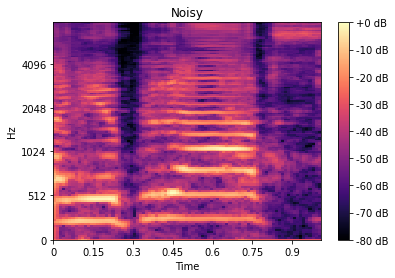

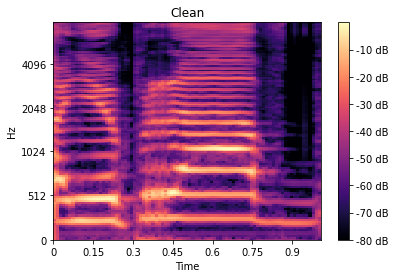

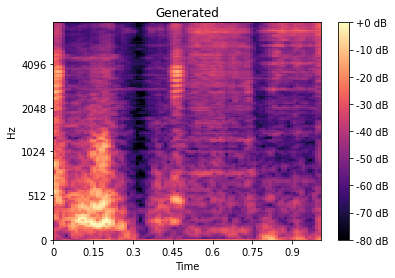

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display


noisy = librosa.feature.melspectrogram(y=noisy, sr=44100, n_mels=128,
                                    fmax=8000)
clean = librosa.feature.melspectrogram(y=clean, sr=44100, n_mels=128,
                                    fmax=8000)
generated = librosa.feature.melspectrogram(y=aud, sr=44100, n_mels=128,
                                    fmax=8000)


sr = 44100
all_data = [noisy, clean, generated]
#fig, ax = plt.subplots(nrows=3, ncols=all_generated.shape[0], sharex=True, figsize=(25,15))
titles = ["Noisy", "Clean", "Generated"]
i =0
for S in all_data:
  fig, ax = plt.subplots()
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
  fig.colorbar(img, ax=ax, format='%+2.0f dB')
  ax.set(title=titles[i])
  fig.show()
  i+= 1

#for i in range(3):
  #for j in range(all_generated.shape[0]):
    #S_dB = librosa.power_to_db(all_data[i][j], ref=np.max)
    #img = librosa.display.specshow(S_dB, x_axis='time',
                                   #y_axis='mel', sr=sr,
                                   #fmax=8000, ax=ax[i,j])

In [ ]:

#G = UNet()
G.load_state_dict(torch.load('generator_100.pth'))

song_index = 5
data = np.array(ds_valid.getFullSongSTFT(song_index)[0])
data = torch.from_numpy(data).unsqueeze(1)
all_generated = G(data).squeeze(1).detach().numpy()
noisy, clean, noisy_phase, clean_phase = ds_valid.getFullSongSTFT(song_index)



In [ ]:
from IPython.display import Audio
print("Generated")
data = ds_train.reconstruct_stft(all_generated)
# aud = librosa.feature.inverse.mel_to_audio(data,44100)
stft_data = librosa.feature.inverse.mel_to_stft(data, 44100) * np.exp(1j * noisy_phase)
aud = librosa.istft(stft_data)
Audio(aud,rate=44100)

In [ ]:
from IPython.display import Audio
print("Noisy")
data = ds_train.reconstruct_stft(noisy)
# aud = librosa.feature.inverse.mel_to_audio(data,44100)
stft_data = librosa.feature.inverse.mel_to_stft(data, 44100) * np.exp(1j * noisy_phase)
aud = librosa.istft(stft_data)
Audio(aud,rate=44100)

In [ ]:
with open (local_path +'results.pkl', 'rb') as fp:
    res = pickle.load(fp)

epoch = [x[0] for x in res]
loss_D = [x[1] for x in res]
loss_G = [x[2] for x in res]
loss_pixel = [x[3] for x in res]
loss_GAN = [x[4] for x in res]

plt.plot(range(len(res)), loss_D, 'r-')
plt.title('Discriminator Loss (0.5 * (loss_real + loss_fake))')
plt.show()

plt.plot(range(len(res)), loss_G, 'g-')
plt.title('Generator Loss (Adversarial Loss + lambda * Pixel-wise Reconstruction Loss)')
plt.show()

plt.plot(range(len(res)), loss_pixel, 'k--')
plt.title('L1 Pixel-wise Reconstruction Loss')
plt.show()

plt.plot(range(len(res)), loss_GAN, 'b-')
plt.title('MSE PatchGAN Adversarial Loss')
plt.show()

In [ ]:
pred = [None,None]
data = ds_train.getFullSongSTFT(0)
pred[0] = generator(torch.from_numpy(data[0][0]).cuda().unsqueeze(0).unsqueeze(1)).squeeze(0).squeeze(0).cpu().detach().numpy()
pred[1] = generator(torch.from_numpy(data[0][1]).cuda().unsqueeze(0).unsqueeze(1)).squeeze(0).squeeze(0).cpu().detach().numpy()
data = ds_train.reconstruct_stft([pred[0],pred[1]])
aud = librosa.feature.inverse.mel_to_audio(data,44100)

In [ ]:
from IPython.display import Audio
Audio(aud,rate=44100)